In [1]:
import numpy as np
from pathlib import Path
from PIL import Image
from torch.utils.data import DataLoader, random_split
import torch
from torch import optim
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import logging
from evaluate import evaluate

import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import OrderedDict

from model.ensemblenet_model import EnsembleNet


from utils.dice_score import dice_loss
from utils.data_load import KittiDataset
from torchsummaryX import summary

In [2]:
Val_Percent = 0.3
Scale_Percent = 1.0
Batch_Size = 8
learning_rate = 0.0001
Pin_Memory = False
epochs = 50


Image_Size = [384, 1216]
Gradient_Clipping = 0.8


Num_Class = 2
Num_Channel = 3
amp = True

Model_Name = 'segnet'


Img_Path =  'data/data_road/training/image_2'
Mask_Path =  'data/data_road/training/semantic'

save_checkpoint = True
checkpoint_dir = '../trained' + '_' + Model_Name
batch_size = Batch_Size

In [3]:
dirImg = Path(Img_Path)
dirMask = Path(Mask_Path)
dir_checkpoint = Path(checkpoint_dir)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
datasets =  KittiDataset(dirImg, dirMask, Image_Size, Scale_Percent)
n_val = int(len(datasets) * Val_Percent)
n_train = len(datasets) - n_val
train_set, val_set = random_split(datasets, [n_train, n_val], generator=torch.Generator().manual_seed(0))

loader_args = dict(batch_size=Batch_Size, num_workers= os.cpu_count(), pin_memory=Pin_Memory)
train_loader = DataLoader(train_set, shuffle=True, drop_last = True, **loader_args)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

100%|██████████| 289/289 [00:00<00:00, 792.85it/s]


In [6]:
model = EnsembleNet(Model_Name, Num_Channel, Num_Class)
model = model.to(memory_format=torch.channels_last, device = device)

In [7]:
# 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
#optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)

if 'ensemble_voting' in Model_Name:
    unet_optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    segnet_optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    enet_optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    optims = [unet_optimizer, segnet_optimizer, enet_optimizer]
    
    unet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(unet_optimizer, 'max', patience=2)  # goal: maximize Dice score
    segnet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(segnet_optimizer, 'max', patience=2)  # goal: maximize Dice score
    enet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(enet_optimizer, 'max', patience=2)  # goal: maximize Dice score
    
else:
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    optims = [optimizer]
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    
        
grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
criterion = nn.CrossEntropyLoss()
global_step = 0

In [8]:
def calculate_loss(pred, true_masks, nclass, multiclass):
    loss = criterion(pred, true_masks)
    loss += dice_loss(
        F.softmax(pred, dim=1).float(),
        F.one_hot(true_masks, nclass).permute(0, 3, 1, 2).float(),
        multiclass=multiclass
    )
    return loss

def grad_forback(models, losses, optim):
    optim.zero_grad(set_to_none=True)
    grad_scaler.scale(losses).backward()
    torch.nn.utils.clip_grad_norm_(models.parameters(), Gradient_Clipping)
    grad_scaler.step(optim)
    grad_scaler.update()    

def forward_and_backward(model, images, true_masks, amp, optimizers, grad_scaler, model_name):
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        
        try:
            mn_cls = model.n_classes
        except:
            mn_cls = model.classifier[-1].out_channels

        if model_name == 'ensemble_voting':
            unet_pred, segnet_pred, enet_pred = model(images)
            #deeplab_pred = deeplab_pred['out']
            
            unet_loss = calculate_loss(unet_pred, true_masks, mn_cls, multiclass=True)
            segnet_loss = calculate_loss(segnet_pred, true_masks, mn_cls, multiclass=True)
            enet_loss = calculate_loss(enet_pred, true_masks, mn_cls, multiclass=True)
            
            
        else:
            masks_pred = model(images)
            if isinstance(masks_pred, OrderedDict):
                masks_pred = masks_pred['out']
            loss = calculate_loss(masks_pred, true_masks, mn_cls, multiclass=True)
    
    
    if model_name == 'ensemble_voting':
        for _loss, _optiz in zip([unet_loss, segnet_loss, enet_loss], optimizers):
            grad_forback(model, _loss, _optiz)

        return model, unet_loss, segnet_loss, enet_loss
    else:
        for _loss, _optiz in zip([loss], optimizers):
            grad_forback(model, _loss, _optiz)
            
        return model, loss


In [9]:
valScore_list1 = []
TrainLoss_list1 = []

valScore_list2 = []
TrainLoss_list2 = []

valScore_list3 = []
TrainLoss_list3 = []

valScore_list4 = []
TrainLoss_list4 = []

val_losses = []
val_accs = []
val_mious = []

# 5. Begin training
for epoch in range(1, epochs + 1):
    model.train()
    epoch_loss = 0
    epoch_unet_loss = 0
    epoch_segnet_loss = 0
    epoch_enet_loss = 0
    epoch_voting_loss = 0
    
    with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
        for batch in train_loader:
            images, true_masks = batch['image'], batch['mask']

            images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            true_masks = true_masks.to(device=device, dtype=torch.long)

                
            result = forward_and_backward(model, images, true_masks, amp, optims, grad_scaler, Model_Name)
            
            if len(result) == 4:
                model, unet_loss, segnet_loss, enet_loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_unet_loss += unet_loss.item()
                epoch_segnet_loss += segnet_loss.item()
                epoch_enet_loss += enet_loss.item()
                vot_loss = ((unet_loss.item() + segnet_loss.item() + enet_loss.item()) /3)
                epoch_voting_loss += vot_loss
                
                
            elif len(result) == 2:
                model, loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()


        print('***')
        if len(result) == 4:
            print('Unet Loss: {}     Segnet Loss: {}     Enet Loss: {}'.format(unet_loss, segnet_loss, enet_loss))
            print('Voting Loss: {}'.format(vot_loss))
            
            
        elif len(result) == 2:
            print('{} Loss: {}'.format(Model_Name, loss))

        # Evaluation round
        division_step = (n_train // (5 * batch_size))
        if division_step > 0:
            #if global_step % division_step == 0:
            if len(result) == 4:
                unet_val_score, segnet_val_score, enet_val_score, voting_val_score, val_loss, val_acc, val_miou = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                unet_scheduler.step(unet_val_score)
                segnet_scheduler.step(segnet_val_score)
                enet_scheduler.step(enet_val_score)
                #voting_scheduler.step(voting_val_score)
                
                valScore_list1.append(unet_val_score.cpu().detach().numpy())
                TrainLoss_list1.append(unet_loss.cpu().detach().numpy())
                valScore_list2.append(segnet_val_score.cpu().detach().numpy())
                TrainLoss_list2.append(segnet_loss.cpu().detach().numpy())                
                valScore_list3.append(enet_val_score.cpu().detach().numpy())
                TrainLoss_list3.append(enet_loss.cpu().detach().numpy())
                valScore_list4.append(voting_val_score.cpu().detach().numpy())
                TrainLoss_list4.append(vot_loss)
                
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_mious.append(val_miou)
                
                print('---')
                print('Unet Validation Dice Score: {}     Segnet Validation Dice Score: {}     Enet Validation Dice Score: {}'.format(unet_val_score, segnet_val_score, enet_val_score))
                print('---')
                print('Ensemble Voting Validation Dice Loss: {}'.format(val_loss))
                print('Ensemble Voting Validation Pixel Accuracy: {} '.format(val_acc))
                print('Ensemble Voting Validation MIoU: {}'.format(val_miou))                
                print('Ensemble Voting Validation Dice Score: {} '.format(voting_val_score))
                
            else:
                val_score, val_loss, val_acc, val_miou = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                                
                scheduler.step(val_score)
                
                print('---')
                print('{} Validation Dice Loss: {}'.format(Model_Name, val_loss))   
                print('{} Validation Pixel Accuracy: {}'.format(Model_Name, val_acc))
                print('{} Validation MIoU: {}'.format(Model_Name, val_miou))
                print('{} Validation Dice Score: {}'.format(Model_Name, val_score))
                
            
                valScore_list1.append(val_score.cpu().detach().numpy())
                TrainLoss_list1.append(loss.cpu().detach().numpy())
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_mious.append(val_miou)

        
    if save_checkpoint:
        Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
        torch.save(model.state_dict(), str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch + 1)))

Epoch 1/50:  99%|█████████▊| 200/203 [00:09<00:00, 41.54img/s]

***
segnet Loss: 0.6014041900634766


Epoch 1/50:  99%|█████████▊| 200/203 [00:13<00:00, 14.32img/s]


---
segnet Validation Dice Loss: 0.5630789995193481
segnet Validation Pixel Accuracy: 0.8509558962102521
segnet Validation MIoU: 0.4314906960002931
segnet Validation Dice Score: 0.02650812268257141


Epoch 2/50:  99%|█████████▊| 200/203 [00:07<00:00, 41.24img/s]

***
segnet Loss: 0.36267799139022827


Epoch 2/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.14img/s]


---
segnet Validation Dice Loss: 0.3801804780960083
segnet Validation Pixel Accuracy: 0.9016255161218476
segnet Validation MIoU: 0.6822798391652104
segnet Validation Dice Score: 0.6860635876655579


Epoch 3/50:  99%|█████████▊| 200/203 [00:07<00:00, 41.30img/s]

***
segnet Loss: 0.3060125708580017


Epoch 3/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.64img/s]


---
segnet Validation Dice Loss: 0.30748119950294495
segnet Validation Pixel Accuracy: 0.9315937778405976
segnet Validation MIoU: 0.7849519141654147
segnet Validation Dice Score: 0.7898711562156677


Epoch 4/50:  99%|█████████▊| 200/203 [00:07<00:00, 41.79img/s]

***
segnet Loss: 0.24818457663059235


Epoch 4/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.12img/s]


---
segnet Validation Dice Loss: 0.28256553411483765
segnet Validation Pixel Accuracy: 0.9276663796943531
segnet Validation MIoU: 0.7803266926212504
segnet Validation Dice Score: 0.8118664026260376


Epoch 5/50:  99%|█████████▊| 200/203 [00:07<00:00, 41.60img/s]

***
segnet Loss: 0.19853052496910095


Epoch 5/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.11img/s]


---
segnet Validation Dice Loss: 0.23902839422225952
segnet Validation Pixel Accuracy: 0.9436343009011787
segnet Validation MIoU: 0.814540675881325
segnet Validation Dice Score: 0.8265151381492615


Epoch 6/50:  99%|█████████▊| 200/203 [00:07<00:00, 41.42img/s]

***
segnet Loss: 0.1254279613494873


Epoch 6/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.36img/s]


---
segnet Validation Dice Loss: 0.2792898416519165
segnet Validation Pixel Accuracy: 0.9300933302494517
segnet Validation MIoU: 0.7935085929767799
segnet Validation Dice Score: 0.8424912691116333


Epoch 7/50:  99%|█████████▊| 200/203 [00:07<00:00, 41.28img/s]

***
segnet Loss: 0.15405887365341187


Epoch 7/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.78img/s]


---
segnet Validation Dice Loss: 0.23406897485256195
segnet Validation Pixel Accuracy: 0.9407873320997807
segnet Validation MIoU: 0.8110664571039885
segnet Validation Dice Score: 0.8630327582359314


Epoch 8/50:  99%|█████████▊| 200/203 [00:07<00:00, 41.29img/s]

***
segnet Loss: 0.1521528959274292


Epoch 8/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.48img/s]


---
segnet Validation Dice Loss: 0.23151756823062897
segnet Validation Pixel Accuracy: 0.9413591351425439
segnet Validation MIoU: 0.8038335072556057
segnet Validation Dice Score: 0.8565255403518677


Epoch 9/50:  99%|█████████▊| 200/203 [00:07<00:00, 41.26img/s]

***
segnet Loss: 0.11446204036474228


Epoch 9/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.92img/s]


---
segnet Validation Dice Loss: 0.1934925764799118
segnet Validation Pixel Accuracy: 0.9494280898780153
segnet Validation MIoU: 0.8332780636070367
segnet Validation Dice Score: 0.8362408876419067


Epoch 10/50:  99%|█████████▊| 200/203 [00:07<00:00, 41.14img/s]

***
segnet Loss: 0.14193396270275116


Epoch 10/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.22img/s]


---
segnet Validation Dice Loss: 0.16163644194602966
segnet Validation Pixel Accuracy: 0.9582813999109101
segnet Validation MIoU: 0.8535257973823982
segnet Validation Dice Score: 0.8474289178848267


Epoch 11/50:  99%|█████████▊| 200/203 [00:07<00:00, 41.30img/s]

***
segnet Loss: 0.07486549019813538


Epoch 11/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.70img/s]


---
segnet Validation Dice Loss: 0.1791175901889801
segnet Validation Pixel Accuracy: 0.9539572732490406
segnet Validation MIoU: 0.8471657055015702
segnet Validation Dice Score: 0.888978123664856


Epoch 12/50:  99%|█████████▊| 200/203 [00:07<00:00, 40.95img/s]

***
segnet Loss: 0.0863078385591507


Epoch 12/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.88img/s]


---
segnet Validation Dice Loss: 0.15539619326591492
segnet Validation Pixel Accuracy: 0.9611583508943257
segnet Validation MIoU: 0.8654951071315832
segnet Validation Dice Score: 0.892181396484375


Epoch 13/50:  99%|█████████▊| 200/203 [00:07<00:00, 41.02img/s]

***
segnet Loss: 0.06807185709476471


Epoch 13/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.22img/s]


---
segnet Validation Dice Loss: 0.16010098159313202
segnet Validation Pixel Accuracy: 0.9608462149636787
segnet Validation MIoU: 0.866125068602436
segnet Validation Dice Score: 0.8931180834770203


Epoch 14/50:  99%|█████████▊| 200/203 [00:07<00:00, 41.27img/s]

***
segnet Loss: 0.08289651572704315


Epoch 14/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.86img/s]


---
segnet Validation Dice Loss: 0.17071163654327393
segnet Validation Pixel Accuracy: 0.9578102513363487
segnet Validation MIoU: 0.8583107213034817
segnet Validation Dice Score: 0.8976613283157349


Epoch 15/50:  99%|█████████▊| 200/203 [00:07<00:00, 41.03img/s]

***
segnet Loss: 0.08175932615995407


Epoch 15/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.28img/s]


---
segnet Validation Dice Loss: 0.16713854670524597
segnet Validation Pixel Accuracy: 0.9587046305338541
segnet Validation MIoU: 0.8603825880463634
segnet Validation Dice Score: 0.9057953953742981


Epoch 16/50:  99%|█████████▊| 200/203 [00:07<00:00, 41.24img/s]

***
segnet Loss: 0.05918256193399429


Epoch 16/50:  99%|█████████▊| 200/203 [00:11<00:00, 17.98img/s]


---
segnet Validation Dice Loss: 0.16016703844070435
segnet Validation Pixel Accuracy: 0.960964002107319
segnet Validation MIoU: 0.8677551666722683
segnet Validation Dice Score: 0.8987045288085938


Epoch 17/50:  99%|█████████▊| 200/203 [00:07<00:00, 40.90img/s]

***
segnet Loss: 0.06359419226646423


Epoch 17/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.75img/s]


---
segnet Validation Dice Loss: 0.15758183598518372
segnet Validation Pixel Accuracy: 0.9616589462547972
segnet Validation MIoU: 0.8688446216682391
segnet Validation Dice Score: 0.9029316306114197


Epoch 18/50:  99%|█████████▊| 200/203 [00:07<00:00, 40.77img/s]

***
segnet Loss: 0.07005633413791656


Epoch 18/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.44img/s]


---
segnet Validation Dice Loss: 0.16800853610038757
segnet Validation Pixel Accuracy: 0.959393953022204
segnet Validation MIoU: 0.8638299227981998
segnet Validation Dice Score: 0.9049376845359802


Epoch 19/50:  99%|█████████▊| 200/203 [00:07<00:00, 40.84img/s]

***
segnet Loss: 0.05447312444448471


Epoch 19/50:  99%|█████████▊| 200/203 [00:11<00:00, 18.11img/s]


---
segnet Validation Dice Loss: 0.16289618611335754
segnet Validation Pixel Accuracy: 0.9601373505174068
segnet Validation MIoU: 0.8654903491800509
segnet Validation Dice Score: 0.9061456918716431


Epoch 20/50:  99%|█████████▊| 200/203 [00:07<00:00, 40.88img/s]

***
segnet Loss: 0.06718625128269196


Epoch 20/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.67img/s]


---
segnet Validation Dice Loss: 0.17782184481620789
segnet Validation Pixel Accuracy: 0.9568079898231908
segnet Validation MIoU: 0.8569632175409081
segnet Validation Dice Score: 0.9052826762199402


Epoch 21/50:  99%|█████████▊| 200/203 [00:07<00:00, 40.84img/s]

***
segnet Loss: 0.0621807798743248


Epoch 21/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.54img/s]


---
segnet Validation Dice Loss: 0.18453814089298248
segnet Validation Pixel Accuracy: 0.9555824681332237
segnet Validation MIoU: 0.8538042699412685
segnet Validation Dice Score: 0.9056607484817505


Epoch 22/50:  99%|█████████▊| 200/203 [00:07<00:00, 40.74img/s]

***
segnet Loss: 0.05987713113427162


Epoch 22/50:  99%|█████████▊| 200/203 [00:11<00:00, 17.65img/s]


---
segnet Validation Dice Loss: 0.1597055345773697
segnet Validation Pixel Accuracy: 0.9610226279810855
segnet Validation MIoU: 0.8678493569621542
segnet Validation Dice Score: 0.9062122702598572


Epoch 23/50:  99%|█████████▊| 200/203 [00:07<00:00, 40.81img/s]

***
segnet Loss: 0.08749119192361832


Epoch 23/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.71img/s]


---
segnet Validation Dice Loss: 0.15782257914543152
segnet Validation Pixel Accuracy: 0.9615355374520285
segnet Validation MIoU: 0.8685233691377241
segnet Validation Dice Score: 0.9035695195198059


Epoch 24/50:  99%|█████████▊| 200/203 [00:07<00:00, 40.94img/s]

***
segnet Loss: 0.07965818047523499


Epoch 24/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.81img/s]


---
segnet Validation Dice Loss: 0.18126192688941956
segnet Validation Pixel Accuracy: 0.9566441586143092
segnet Validation MIoU: 0.8571335617114719
segnet Validation Dice Score: 0.9028235673904419


Epoch 25/50:  99%|█████████▊| 200/203 [00:07<00:00, 40.71img/s]

***
segnet Loss: 0.07528182119131088


Epoch 25/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.23img/s]


---
segnet Validation Dice Loss: 0.15765607357025146
segnet Validation Pixel Accuracy: 0.9619239673279879
segnet Validation MIoU: 0.8706159737576424
segnet Validation Dice Score: 0.902436375617981


Epoch 26/50:  99%|█████████▊| 200/203 [00:07<00:00, 40.93img/s]

***
segnet Loss: 0.10327047109603882


Epoch 26/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.49img/s]


---
segnet Validation Dice Loss: 0.14567700028419495
segnet Validation Pixel Accuracy: 0.9652249520285088
segnet Validation MIoU: 0.879157919316306
segnet Validation Dice Score: 0.9044370651245117


Epoch 27/50:  99%|█████████▊| 200/203 [00:07<00:00, 41.10img/s]

***
segnet Loss: 0.06664016842842102


Epoch 27/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.73img/s]


---
segnet Validation Dice Loss: 0.16297663748264313
segnet Validation Pixel Accuracy: 0.9598420795641447
segnet Validation MIoU: 0.86523388625122
segnet Validation Dice Score: 0.899886429309845


Epoch 28/50:  99%|█████████▊| 200/203 [00:07<00:00, 41.11img/s]

***
segnet Loss: 0.09865365922451019


Epoch 28/50:  99%|█████████▊| 200/203 [00:11<00:00, 18.00img/s]


---
segnet Validation Dice Loss: 0.14737969636917114
segnet Validation Pixel Accuracy: 0.9649527031078673
segnet Validation MIoU: 0.8776710472703881
segnet Validation Dice Score: 0.9038833975791931


Epoch 29/50:  99%|█████████▊| 200/203 [00:07<00:00, 40.60img/s]

***
segnet Loss: 0.076382115483284


Epoch 29/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.75img/s]


---
segnet Validation Dice Loss: 0.16868072748184204
segnet Validation Pixel Accuracy: 0.9589798241330866
segnet Validation MIoU: 0.8621210885772242
segnet Validation Dice Score: 0.906453549861908


Epoch 30/50:  99%|█████████▊| 200/203 [00:07<00:00, 40.92img/s]

***
segnet Loss: 0.07432933896780014


Epoch 30/50:  99%|█████████▊| 200/203 [00:11<00:00, 18.14img/s]


---
segnet Validation Dice Loss: 0.14785701036453247
segnet Validation Pixel Accuracy: 0.9648571349026864
segnet Validation MIoU: 0.8780480262025403
segnet Validation Dice Score: 0.8990380167961121


Epoch 31/50:  99%|█████████▊| 200/203 [00:07<00:00, 40.72img/s]

***
segnet Loss: 0.06234942004084587


Epoch 31/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.58img/s]


---
segnet Validation Dice Loss: 0.14681322872638702
segnet Validation Pixel Accuracy: 0.9641287284984923
segnet Validation MIoU: 0.8763002247233369
segnet Validation Dice Score: 0.9048905372619629


Epoch 32/50:  99%|█████████▊| 200/203 [00:07<00:00, 40.79img/s]

***
segnet Loss: 0.06476252526044846


Epoch 32/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.63img/s]


---
segnet Validation Dice Loss: 0.15898120403289795
segnet Validation Pixel Accuracy: 0.9609514202987939
segnet Validation MIoU: 0.8670460513147031
segnet Validation Dice Score: 0.903790295124054


Epoch 33/50:  99%|█████████▊| 200/203 [00:07<00:00, 40.52img/s]

***
segnet Loss: 0.06095336750149727


Epoch 33/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.92img/s]


---
segnet Validation Dice Loss: 0.16413699090480804
segnet Validation Pixel Accuracy: 0.9600024306983278
segnet Validation MIoU: 0.865578195253851
segnet Validation Dice Score: 0.9019675254821777


Epoch 34/50:  99%|█████████▊| 200/203 [00:07<00:00, 40.77img/s]

***
segnet Loss: 0.10136812925338745


Epoch 34/50:  99%|█████████▊| 200/203 [00:11<00:00, 17.91img/s]


---
segnet Validation Dice Loss: 0.14091815054416656
segnet Validation Pixel Accuracy: 0.9665845904433936
segnet Validation MIoU: 0.8823101917964056
segnet Validation Dice Score: 0.8982647061347961


Epoch 35/50:  99%|█████████▊| 200/203 [00:07<00:00, 40.30img/s]

***
segnet Loss: 0.06947602331638336


Epoch 35/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.99img/s]


---
segnet Validation Dice Loss: 0.1478806734085083
segnet Validation Pixel Accuracy: 0.9643166525322094
segnet Validation MIoU: 0.8765409665530083
segnet Validation Dice Score: 0.9021759033203125


Epoch 36/50:  99%|█████████▊| 200/203 [00:07<00:00, 40.19img/s]

***
segnet Loss: 0.08703590929508209


Epoch 36/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.25img/s]


---
segnet Validation Dice Loss: 0.1585259735584259
segnet Validation Pixel Accuracy: 0.961578369140625
segnet Validation MIoU: 0.8682524646040763
segnet Validation Dice Score: 0.9083966612815857


Epoch 37/50:  99%|█████████▊| 200/203 [00:07<00:00, 40.48img/s]

***
segnet Loss: 0.0715789794921875


Epoch 37/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.64img/s]


---
segnet Validation Dice Loss: 0.14054468274116516
segnet Validation Pixel Accuracy: 0.9663605271724233
segnet Validation MIoU: 0.8820017967346789
segnet Validation Dice Score: 0.9005530476570129


Epoch 38/50:  99%|█████████▊| 200/203 [00:07<00:00, 40.29img/s]

***
segnet Loss: 0.06802305579185486


Epoch 38/50:  99%|█████████▊| 200/203 [00:11<00:00, 17.40img/s]


---
segnet Validation Dice Loss: 0.158738374710083
segnet Validation Pixel Accuracy: 0.9616091544168037
segnet Validation MIoU: 0.8699933097051287
segnet Validation Dice Score: 0.9018521308898926


Epoch 39/50:  99%|█████████▊| 200/203 [00:07<00:00, 40.66img/s]

***
segnet Loss: 0.06047624349594116


Epoch 39/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.59img/s]


---
segnet Validation Dice Loss: 0.16121643781661987
segnet Validation Pixel Accuracy: 0.9604393139220121
segnet Validation MIoU: 0.8664516884371563
segnet Validation Dice Score: 0.903638482093811


Epoch 40/50:  99%|█████████▊| 200/203 [00:07<00:00, 40.50img/s]

***
segnet Loss: 0.07903038710355759


Epoch 40/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.32img/s]


---
segnet Validation Dice Loss: 0.15481457114219666
segnet Validation Pixel Accuracy: 0.9629786976596766
segnet Validation MIoU: 0.8733008140687093
segnet Validation Dice Score: 0.9034587144851685


Epoch 41/50:  99%|█████████▊| 200/203 [00:07<00:00, 40.43img/s]

***
segnet Loss: 0.05719044804573059


Epoch 41/50:  99%|█████████▊| 200/203 [00:11<00:00, 18.12img/s]


---
segnet Validation Dice Loss: 0.16858556866645813
segnet Validation Pixel Accuracy: 0.9584995738246984
segnet Validation MIoU: 0.8605253713686487
segnet Validation Dice Score: 0.9080427289009094


Epoch 42/50:  99%|█████████▊| 200/203 [00:07<00:00, 39.86img/s]

***
segnet Loss: 0.061225082725286484


Epoch 42/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.61img/s]


---
segnet Validation Dice Loss: 0.16428670287132263
segnet Validation Pixel Accuracy: 0.9592946370442709
segnet Validation MIoU: 0.8626607639884076
segnet Validation Dice Score: 0.9027091264724731


Epoch 43/50:  99%|█████████▊| 200/203 [00:07<00:00, 40.56img/s]

***
segnet Loss: 0.0823407918214798


Epoch 43/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.22img/s]


---
segnet Validation Dice Loss: 0.14025485515594482
segnet Validation Pixel Accuracy: 0.9665107057805646
segnet Validation MIoU: 0.881963313267569
segnet Validation Dice Score: 0.8988721966743469


Epoch 44/50:  99%|█████████▊| 200/203 [00:07<00:00, 40.68img/s]

***
segnet Loss: 0.070187509059906


Epoch 44/50:  99%|█████████▊| 200/203 [00:11<00:00, 17.73img/s]


---
segnet Validation Dice Loss: 0.1638222187757492
segnet Validation Pixel Accuracy: 0.9596362197608278
segnet Validation MIoU: 0.864760861467651
segnet Validation Dice Score: 0.9028218388557434


Epoch 45/50:  99%|█████████▊| 200/203 [00:07<00:00, 40.62img/s]

***
segnet Loss: 0.05467072129249573


Epoch 45/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.47img/s]


---
segnet Validation Dice Loss: 0.16632679104804993
segnet Validation Pixel Accuracy: 0.959638093647204
segnet Validation MIoU: 0.8644515712414744
segnet Validation Dice Score: 0.9046788215637207


Epoch 46/50:  99%|█████████▊| 200/203 [00:07<00:00, 40.79img/s]

***
segnet Loss: 0.06733642518520355


Epoch 46/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.35img/s]


---
segnet Validation Dice Loss: 0.15563488006591797
segnet Validation Pixel Accuracy: 0.962070665861431
segnet Validation MIoU: 0.8705564161876209
segnet Validation Dice Score: 0.9059478640556335


Epoch 47/50:  99%|█████████▊| 200/203 [00:07<00:00, 40.65img/s]

***
segnet Loss: 0.06342201679944992


Epoch 47/50:  99%|█████████▊| 200/203 [00:11<00:00, 17.77img/s]


---
segnet Validation Dice Loss: 0.15774816274642944
segnet Validation Pixel Accuracy: 0.9615596302768641
segnet Validation MIoU: 0.8683181353884957
segnet Validation Dice Score: 0.907535970211029


Epoch 48/50:  99%|█████████▊| 200/203 [00:07<00:00, 40.82img/s]

***
segnet Loss: 0.08218992501497269


Epoch 48/50:  99%|█████████▊| 200/203 [00:11<00:00, 17.55img/s]


---
segnet Validation Dice Loss: 0.19360731542110443
segnet Validation Pixel Accuracy: 0.9537763093647204
segnet Validation MIoU: 0.8500172141051421
segnet Validation Dice Score: 0.8996673822402954


Epoch 49/50:  99%|█████████▊| 200/203 [00:07<00:00, 40.71img/s]

***
segnet Loss: 0.07980652153491974


Epoch 49/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.65img/s]


---
segnet Validation Dice Loss: 0.14962293207645416
segnet Validation Pixel Accuracy: 0.9640976755242598
segnet Validation MIoU: 0.8763898603879967
segnet Validation Dice Score: 0.9042865633964539


Epoch 50/50:  99%|█████████▊| 200/203 [00:07<00:00, 40.73img/s]

***
segnet Loss: 0.059160225093364716


Epoch 50/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.40img/s]

---
segnet Validation Dice Loss: 0.19579124450683594
segnet Validation Pixel Accuracy: 0.9535819605777138
segnet Validation MIoU: 0.8490837813142276
segnet Validation Dice Score: 0.9029485583305359


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
df = pd.DataFrame([TrainLoss_list1, val_losses, valScore_list1, val_accs, val_mious]).T
df.columns = ['train_loss', 'val_loss', 'val_score', 'val_acc', 'val_miou']
df.to_csv(checkpoint_dir + '/model_check.csv', encoding = 'UTF-8')

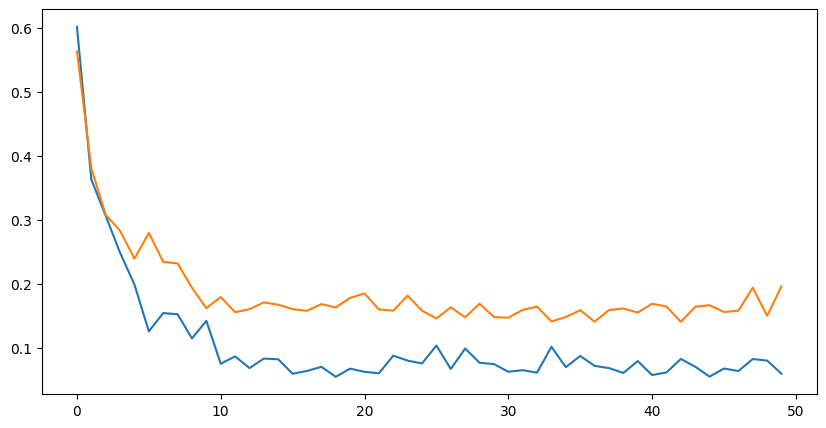

In [12]:
plt.figure(figsize= (10,5))
plt.plot(TrainLoss_list1)
plt.plot(val_losses)

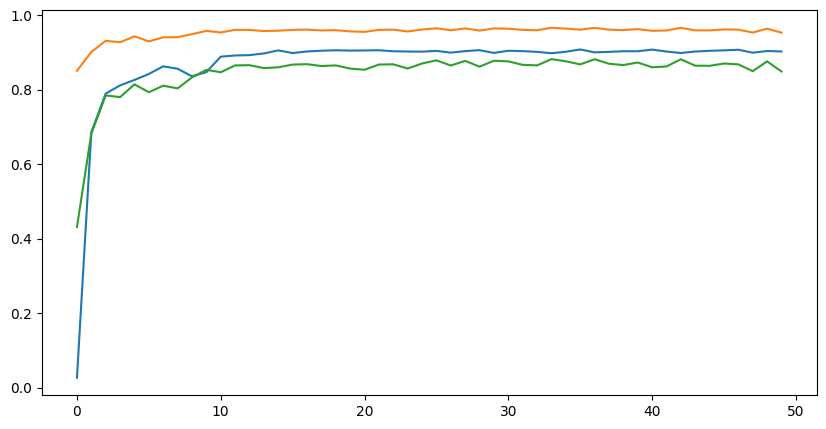

In [13]:
plt.figure(figsize= (10,5))
plt.plot(valScore_list1)
plt.plot(val_accs)
plt.plot(val_mious)